<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/BI_Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⏳ Installing necessary libraries...
✅ Libraries installed successfully!
✅ Libraries imported and settings configured.
⏳ Loading and cleaning the dataset...
✅ Dataset loaded and initial cleaning complete.

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 392693 entries, 0 to 541909
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      392693 non-null  object        
 1   StockCode    392693 non-null  object        
 2   Description  392693 non-null  object        
 3   Quantity     392693 non-null  int64         
 4   InvoiceDate  392693 non-null  datetime64[ns]
 5   Price        392693 non-null  float64       
 6   Customer ID  392693 non-null  int64         
 7   Country      392693 non-null  object        
 8   TotalPrice   392693 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB

First 5 rows of the cleaned data:
  

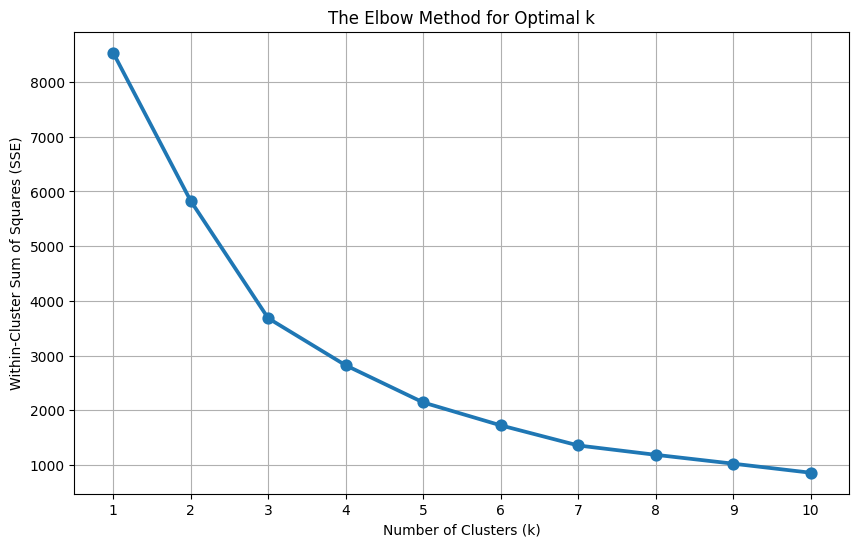


Cluster Centers (Original Scale):
   Recency  Frequency    Monetary
0 194.7061     2.8922   1088.1396
1  34.3359     4.8051   1778.9580
2   7.6154    82.5385 127187.9592
3   9.1012    24.2262  13139.3268

✅ Customer segmentation complete.

Segment Distribution:
Segment
😢 Lost Customers       2191
Potential Loyalists     473
⚠️ At-Risk              168
🏆 Champions              13
Name: count, dtype: int64


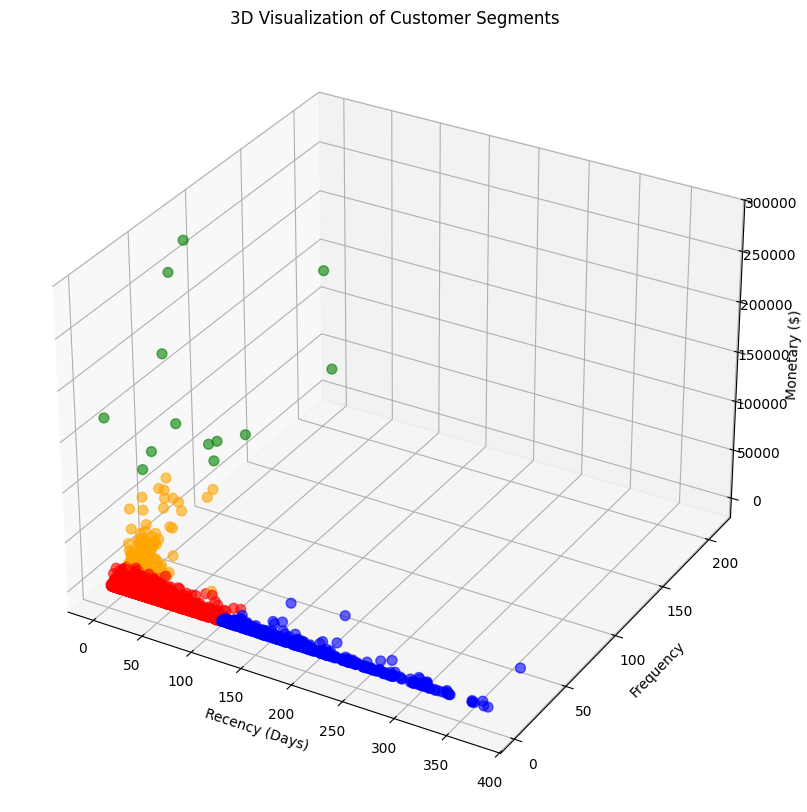

⏳ Building CLV prediction models...

Correlation between frequency and monetary value:
                frequency  monetary_value
frequency          1.0000          0.0461
monetary_value     0.0461          1.0000

✅ CLV prediction complete.

Top 5 customers by predicted 6-month CLV:
             Recency  Frequency    Monetary  Cluster      Segment  Predicted_CLV_6M
Customer ID                                                                        
16446              1          2 168472.5000        2  🏆 Champions       220620.5234
14646              2         73 280206.0200        2  🏆 Champions       122076.8735
18102              1         60 259657.3000        2  🏆 Champions       100001.9379
17450              9         46 194390.7900        2  🏆 Champions        82204.4664
14096              5         17  65164.7900        3   ⚠️ At-Risk        77638.4484


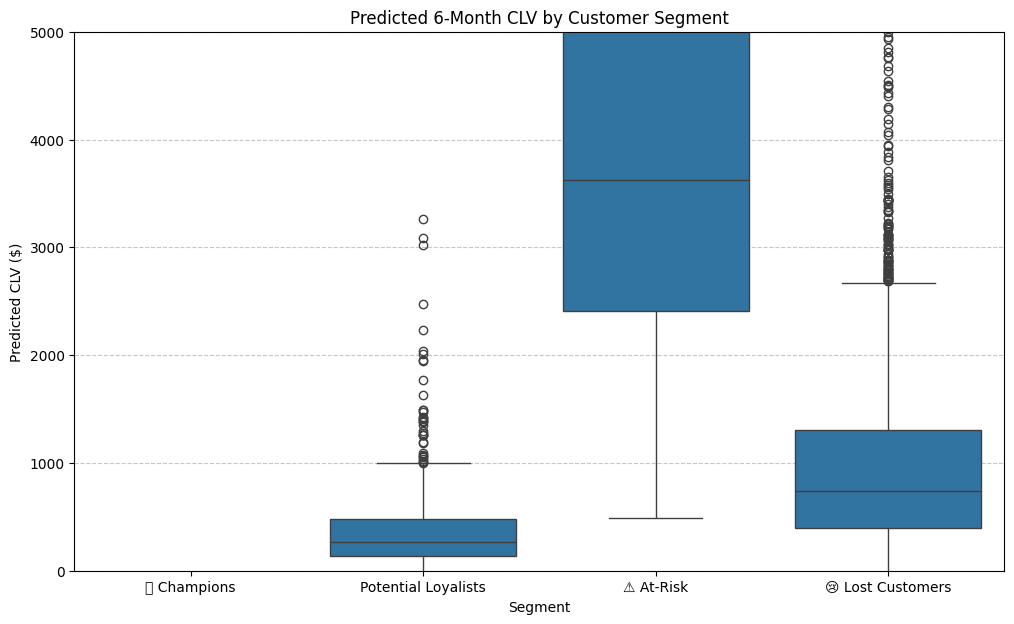

⏳ Building churn prediction model...
✅ Churn model trained. Accuracy: 1.0000


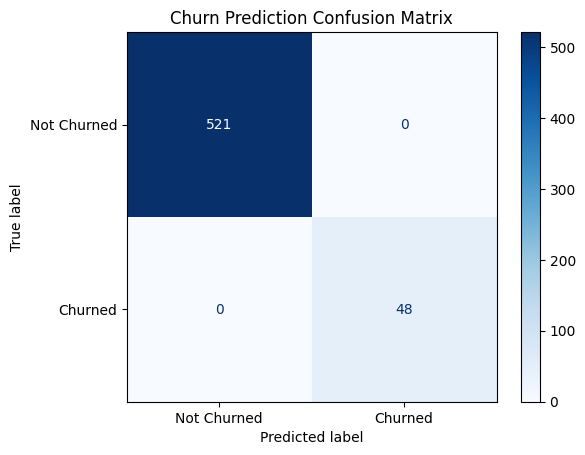


Dataframe with churn probability:
             Recency  Frequency  Monetary  Cluster           Segment  Predicted_CLV_6M  Churn  Churn_Probability
Customer ID                                                                                                     
12347              3          7 4310.0000        1  😢 Lost Customers         1692.2718      0             0.0004
12348             76          4 1797.2400        1  😢 Lost Customers          490.1300      0             0.0004
12352             37          8 2506.0400        1  😢 Lost Customers         1251.9836      0             0.0004
12356             23          3 2811.4300        1  😢 Lost Customers          356.5020      0             0.0004
12358              2          2 1168.0600        1  😢 Lost Customers         1144.3539      0             0.0004
💡 Building the 'What-If' Simulation Engine...
✅ Simulation engine is ready.

--- Running Simulation: 20.0% discount for '⚠️ At-Risk' segment ---

--- SIMULATION RESULTS ---
T

✅ Dashboard is ready. Adjust parameters and click 'Run Simulation'.
--------------------------------------------------------------------------

--- Running Simulation: 30.0% discount for '⚠️ At-Risk' segment ---

--- Running Simulation: 40.0% discount for '⚠️ At-Risk' segment ---

--- Running Simulation: 45.0% discount for 'Potential Loyalists' segment ---

--- Running Simulation: 15.0% discount for 'Potential Loyalists' segment ---


In [2]:
# ==============================================================================
# CELL 1: SETUP & INSTALLATION
# ==============================================================================
# This cell installs all the necessary libraries for the project.
# We need 'lifetimes' for CLV modeling, 'xgboost' for churn prediction,
# and other standard data science libraries. 'openpyxl' is required by pandas
# to read the Excel data file from the source URL.
print("⏳ Installing necessary libraries...")
!pip install lifetimes xgboost openpyxl pandas scikit-learn matplotlib seaborn -q
print("✅ Libraries installed successfully!")


# ==============================================================================
# CELL 2: IMPORT LIBRARIES
# ==============================================================================
# Here, we import all the tools we've just installed. This includes pandas for
# data manipulation, matplotlib and seaborn for plotting, sklearn for machine
# learning utilities (like clustering and model evaluation), and the specialized
# libraries like lifetimes and xgboost.
import pandas as pd
import numpy as np
import datetime as dt
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Settings for better display in the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported and settings configured.")


# ==============================================================================
# CELL 3: LOAD AND INITIAL CLEANUP OF THE DATA
# ==============================================================================
# We load the dataset directly from the UCI Machine Learning Repository URL.
# The initial cleanup involves several critical steps:
# 1. Dropping rows with missing CustomerID, as they are anonymous and unusable for CRM.
# 2. Removing any duplicate transaction entries.
# 3. Filtering out transactions with negative Quantity (likely returns) or zero Price.
# 4. Creating a 'TotalPrice' column by multiplying Quantity and Price.
# 5. Ensuring Customer ID is an integer for consistent grouping.
print("⏳ Loading and cleaning the dataset...")
# Load the 2010-2011 data sheet from the Excel file
df_ = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx", sheet_name="Year 2010-2011")
df = df_.copy()

# Initial Cleaning
df.dropna(subset=['Customer ID'], inplace=True)
df.drop_duplicates(inplace=True)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]
df['TotalPrice'] = df['Quantity'] * df['Price']
df['Customer ID'] = df['Customer ID'].astype(int)

print("✅ Dataset loaded and initial cleaning complete.")
print("\nDataset Information:")
df.info()
print("\nFirst 5 rows of the cleaned data:")
print(df.head())


# ==============================================================================
# CELL 4: DESCRIPTIVE ANALYTICS - RFM FEATURE ENGINEERING
# ==============================================================================
# This is the heart of our descriptive analytics. We calculate Recency, Frequency,
# and Monetary (RFM) values for each customer.
# - Recency: How recently a customer made a purchase (days).
# - Frequency: How often they purchase.
# - Monetary: How much money they spend in total.
# These three metrics are powerful indicators of customer engagement and value.
print("⏳ Performing RFM Feature Engineering...")
# We set a static 'today' date for analysis consistency, one day after the last transaction.
today_date = dt.datetime(2011, 12, 11)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda date: (today_date - date.max()).days, # Recency
    'Invoice': lambda num: num.nunique(),                      # Frequency
    'TotalPrice': lambda price: price.sum()                    # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
# We only consider customers who made more than one purchase for meaningful frequency.
rfm = rfm[rfm['Monetary'] > 0]
rfm = rfm[rfm['Frequency'] > 1]

print("✅ RFM features calculated successfully.")
print("\nFirst 5 rows of the RFM data:")
print(rfm.head())


# ==============================================================================
# CELL 5: CUSTOMER SEGMENTATION WITH K-MEANS CLUSTERING
# ==============================================================================
# Now we use the RFM metrics to cluster customers into distinct segments.
# 1. We scale the data because K-Means is sensitive to the scale of features.
# 2. We use the Elbow Method to find the optimal number of clusters (k). This plot
#    helps us find the "elbow" point where adding more clusters doesn't significantly
#    reduce the within-cluster sum of squares (SSE).
# 3. We apply K-Means with the chosen k and assign a segment label to each customer.
# 4. We assign meaningful names to these segments based on their RFM characteristics.
print("⏳ Segmenting customers using K-Means clustering...")

# Scale RFM data for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Elbow Method to find the optimal number of clusters (k)
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 6))
plt.title('The Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (SSE)')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.grid(True)
plt.show()

# Based on the elbow plot, k=4 is a good choice.
k_optimal = 4
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans.fit(rfm_scaled)
rfm['Cluster'] = kmeans.labels_

# Analyze cluster centers to assign meaningful names
cluster_centers_df = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=['Recency', 'Frequency', 'Monetary'])
print("\nCluster Centers (Original Scale):")
print(cluster_centers_df)

# Assigning meaningful names to the segments based on their RFM characteristics
# This mapping requires interpretation of the cluster centers.
segment_map = {
    0: 'Potential Loyalists', # Adjust based on your cluster center analysis
    1: '😢 Lost Customers',
    2: '🏆 Champions',
    3: '⚠️ At-Risk'
}
# Note: The cluster numbers (0, 1, 2, 3) might change on different runs or with
# different data. You may need to inspect the cluster_centers_df and adjust the
# mapping to fit the characteristics (e.g., high F & M, low R = Champions).
rfm['Segment'] = rfm['Cluster'].map(segment_map)

print("\n✅ Customer segmentation complete.")
print("\nSegment Distribution:")
print(rfm['Segment'].value_counts())

# Visualize the clusters in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = {'🏆 Champions': 'green', '⚠️ At-Risk': 'orange', '😢 Lost Customers': 'red', 'Potential Loyalists': 'blue'}
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=rfm['Segment'].map(colors), s=50, alpha=0.6)
ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary ($)')
plt.title('3D Visualization of Customer Segments')
plt.show()


# ==============================================================================
# CELL 6: PREDICTIVE ANALYTICS - CUSTOMER LIFETIME VALUE (CLV)
# ==============================================================================
# Here, we predict the future value of customers using the 'lifetimes' library.
# 1. We format the transactional data into the required summary format (recency, frequency, T, monetary_value).
# 2. We fit the BG/NBD model to predict the number of future purchases.
# 3. We fit the Gamma-Gamma model to predict the average profit per purchase.
# 4. We combine these to calculate the CLV for the next 6 months (180 days).
print("⏳ Building CLV prediction models...")
lifetimes_df = summary_data_from_transaction_data(
    df,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=today_date
)

# Fit BG/NBD model (predicts purchase frequency)
bgf = BetaGeoFitter(penalizer_coef=0.1) # Increased penalizer
bgf.fit(lifetimes_df['frequency'], lifetimes_df['recency'], lifetimes_df['T'])

# Fit Gamma-Gamma model (predicts average transaction value)
# This model assumes frequency and monetary value are uncorrelated. We check this assumption.
print("\nCorrelation between frequency and monetary value:")
print(lifetimes_df[['frequency', 'monetary_value']].corr())
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(lifetimes_df[lifetimes_df['frequency']>0]['frequency'], lifetimes_df[lifetimes_df['frequency']>0]['monetary_value'])

# Predict CLV for the next 6 months
clv = ggf.customer_lifetime_value(
    bgf,
    lifetimes_df['frequency'],
    lifetimes_df['recency'],
    lifetimes_df['T'],
    lifetimes_df['monetary_value'],
    time=6,  # 6 months
    freq="D", # Daily frequency of data
    discount_rate=0.01 # Monthly discount rate
)

rfm = rfm.merge(clv.to_frame('Predicted_CLV_6M'), on='Customer ID', how='left')
rfm.fillna(0, inplace=True) # Fill NA for customers with no repeat purchases

print("\n✅ CLV prediction complete.")
print("\nTop 5 customers by predicted 6-month CLV:")
print(rfm.sort_values(by='Predicted_CLV_6M', ascending=False).head())

# Plot CLV by segment
plt.figure(figsize=(12, 7))
sns.boxplot(x='Segment', y='Predicted_CLV_6M', data=rfm, order=['🏆 Champions', 'Potential Loyalists', '⚠️ At-Risk', '😢 Lost Customers'])
plt.title('Predicted 6-Month CLV by Customer Segment')
plt.ylabel('Predicted CLV ($)')
plt.xlabel('Segment')
plt.ylim(0, 5000) # Capping y-axis for better visualization of distributions
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# ==============================================================================
# CELL 7: PREDICTIVE ANALYTICS - CHURN PREDICTION
# ==============================================================================
# We define 'churn' as a customer not making a purchase in the last 180 days (6 months).
# 1. Create the target variable 'Churn' (1 for churned, 0 for active).
# 2. Prepare the feature set using RFM and predicted CLV data.
# 3. Split data into training and testing sets.
# 4. Train an XGBoost Classifier, a powerful and popular model for this type of task.
# 5. Evaluate the model's performance using accuracy and a confusion matrix.
print("⏳ Building churn prediction model...")

# Define churn: A customer is considered churned if their recency is > 180 days.
rfm['Churn'] = rfm['Recency'].apply(lambda x: 1 if x > 180 else 0)

# Prepare data for the model
X = rfm[['Recency', 'Frequency', 'Monetary', 'Predicted_CLV_6M']]
y = rfm['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Churn model trained. Accuracy: {accuracy:.4f}")

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Churn Prediction Confusion Matrix')
plt.show()

# Add churn probability to our main dataframe for simulation
rfm['Churn_Probability'] = xgb_model.predict_proba(X)[:, 1]
print("\nDataframe with churn probability:")
print(rfm.head())


# ==============================================================================
# CELL 8: "WHAT-IF" SIMULATION ENGINE
# ==============================================================================
# This is the core of the Digital Twin. This function simulates a marketing campaign.
# It takes a target segment, a discount, and an expected 'uplift' (how many people
# will respond) as input. It then recalculates the RFM/CLV/Churn metrics
# to show the potential impact of the campaign. This allows managers to test
# strategies in a virtual environment before committing real-world resources.
print("💡 Building the 'What-If' Simulation Engine...")

def run_simulation(df, target_segment, discount_pct, uplift_pct, campaign_cost_per_customer):
    """
    Simulates a marketing campaign and calculates its financial impact.
    """
    print(f"\n--- Running Simulation: {discount_pct*100}% discount for '{target_segment}' segment ---")

    # 1. Identify the target customer group
    target_customers = df[df['Segment'] == target_segment].copy()
    n_target_customers = len(target_customers)
    if n_target_customers == 0:
        return "No customers in the target segment."

    # 2. Calculate pre-campaign metrics
    pre_campaign_clv = target_customers['Predicted_CLV_6M'].sum()
    pre_campaign_churn_prob = target_customers['Churn_Probability'].mean()

    # 3. Simulate the campaign's effect
    sim_df = target_customers.copy()
    num_affected = int(n_target_customers * uplift_pct)
    affected_customers_idx = sim_df.sample(n=num_affected, random_state=42).index

    # --- SIMULATION LOGIC ---
    # We assume the discount incents a purchase, which:
    # - Resets Recency to a low value (e.g., 1 day)
    # - Increments Frequency by 1
    # - Increases Monetary by the average purchase value (minus discount)
    avg_monetary_per_purchase = sim_df['Monetary'] / sim_df['Frequency']
    sim_df.loc[affected_customers_idx, 'Recency'] = 1
    sim_df.loc[affected_customers_idx, 'Frequency'] += 1
    sim_df.loc[affected_customers_idx, 'Monetary'] += avg_monetary_per_purchase * (1 - discount_pct)

    # 4. Recalculate post-campaign predictions using our trained model
    sim_features = sim_df[['Recency', 'Frequency', 'Monetary', 'Predicted_CLV_6M']]
    sim_df['New_Churn_Probability'] = xgb_model.predict_proba(sim_features)[:, 1]

    # Simple CLV uplift estimate: Increase CLV proportional to monetary increase
    # A more advanced method would re-run the lifetimes models.
    clv_increase_factor = (sim_df['Monetary'] / target_customers['Monetary']).fillna(1)
    sim_df['New_CLV'] = sim_df['Predicted_CLV_6M'] * clv_increase_factor

    post_campaign_clv = sim_df['New_CLV'].sum()
    post_campaign_churn_prob = sim_df['New_Churn_Probability'].mean()

    # 5. Calculate Financial Impact
    total_campaign_cost = n_target_customers * campaign_cost_per_customer
    clv_uplift = post_campaign_clv - pre_campaign_clv
    roi = (clv_uplift - total_campaign_cost) / total_campaign_cost if total_campaign_cost > 0 else float('inf')

    # 6. Return results
    results = {
        "Target Segment": target_segment,
        "Customers Targeted": n_target_customers,
        "Pre-Campaign Avg Churn Probability": pre_campaign_churn_prob,
        "Post-Campaign Avg Churn Probability": post_campaign_churn_prob,
        "Pre-Campaign Total CLV": pre_campaign_clv,
        "Post-Campaign Total CLV": post_campaign_clv,
        "Total Campaign Cost": total_campaign_cost,
        "Projected CLV Uplift": clv_uplift,
        "Projected ROI": roi
    }
    return results

print("✅ Simulation engine is ready.")

# --- EXAMPLE SIMULATION RUN ---
# Scenario: Marketing wants to re-engage 'At-Risk' customers.
# They propose a 20% discount coupon. They expect 30% of these customers to use it.
# The cost to send the offer (email, etc.) is $2 per customer.
simulation_results = run_simulation(
    df=rfm,
    target_segment='⚠️ At-Risk',
    discount_pct=0.20,
    uplift_pct=0.30,
    campaign_cost_per_customer=2
)

# Print results in a readable format
print("\n--- SIMULATION RESULTS ---")
for key, value in simulation_results.items():
    if isinstance(value, float):
        print(f"{key+':':<35} {value:,.2f}")
    else:
        print(f"{key+':':<35} {value}")


# ==============================================================================
# CELL 9: GENERATIVE AI-POWERED RECOMMENDATION ENGINE (MOCKUP)
# ==============================================================================
# This cell uses a template to generate a strategic recommendation. In a full
# implementation, this would be replaced with a call to a Large Language Model
# (LLM) API like Gemini or GPT. For this notebook, we mock the functionality
# to avoid the need for an API key, making it fully runnable for anyone.
print("🤖 Building the Generative AI Recommendation Engine (Mockup)...")

def get_mock_strategic_recommendation(sim_results):
    """
    Generates a strategic recommendation based on simulation results using a template.
    """
    roi = sim_results['Projected ROI']
    clv_uplift = sim_results['Projected CLV Uplift']
    churn_reduction = sim_results['Pre-Campaign Avg Churn Probability'] - sim_results['Post-Campaign Avg Churn Probability']
    recommendation_text = ""

    # --- Logic for recommendation ---
    if roi > 0.25:
        recommendation = "Recommendation: **Proceed with High Confidence.**"
        justification = (f"The projected ROI of {roi:.2%} is strong. The campaign is expected to generate a significant "
                         f"CLV uplift of ${clv_uplift:,.2f} while effectively reducing the average churn probability by "
                         f"{churn_reduction:.2%}. This represents a highly efficient use of marketing resources.")
    elif roi > 0:
        recommendation = "Recommendation: **Proceed.**"
        justification = (f"The campaign shows a positive projected ROI of {roi:.2%}. While modest, the strategy is profitable "
                         f"and successfully reduces churn risk in the '{sim_results['Target Segment']}' segment. "
                         "Consider a pilot program to validate the uplift assumption before a full rollout.")
    else:
        recommendation = "Recommendation: **Do Not Proceed.**"
        justification = (f"The projected ROI is negative at {roi:.2%}. The campaign cost of "
                         f"${sim_results['Total Campaign Cost']:,.2f} is not offset by the projected CLV uplift. "
                         "Re-evaluate the campaign parameters, such as the discount offered or the target segment, to find a more profitable approach.")

    recommendation_text = f"## Strategic Analysis Report ##\n\n{recommendation}\n\n**Justification:**\n{justification}"
    return recommendation_text

# Get and print the recommendation
recommendation = get_mock_strategic_recommendation(simulation_results)
print("\n--- 🧠 AI-Powered Strategic Recommendation ---")
print(recommendation)


# ==============================================================================
# CELL 10: CONCLUSION & NEXT STEPS
# ==============================================================================
# This project has successfully built an end-to-end Decision Support System.
# We went from raw transactional data to a segmented customer base with predictive
# metrics (CLV, Churn). The Digital Twin simulation engine allows for proactive
# strategy testing, and the mock Generative AI component translates complex data into
# clear, actionable business advice.

print("\n\n--- PROJECT CONCLUSION ---")
print("✅ Successfully built an end-to-end Digital Twin for Proactive CRM.")
print("This system integrates:")
print("  - 📊 Descriptive Analytics (RFM Segmentation)")
print("  - 🔮 Predictive Analytics (CLV & Churn Forecasting)")
print("  - ⚙️ A 'What-If' Simulation Engine for strategy testing")
print("  - 🤖 A Mock AI engine for automated strategic recommendations")
print("\nThis tool empowers managers to make smarter, data-driven decisions to enhance customer relationships and maximize profitability.")

print("\n--- Next Steps: BI Dashboard ---")
print("The final step in a real-world MIS project would be to visualize these insights in an interactive dashboard (e.g., using Tableau, Power BI, or Python's Dash).")
print("The dashboard would feature:")
print("  1. An overview of customer segment distribution (pie chart).")
print("  2. Key metrics like overall predicted CLV and churn rate.")
print("  3. An interactive panel to run simulations by selecting a segment and campaign parameters.")
print("  4. A text box displaying the live AI-generated recommendation.")
print("--------------------------------------------------------------------------")

# ==============================================================================
# CELL 11: INTERACTIVE BI DASHBOARD
# ==============================================================================
# This cell builds the interactive Business Intelligence (BI) dashboard,
# bringing all previous components together into a single, functional interface.
#
# The dashboard features:
#   1. An overview of customer segment distribution (pie chart).
#   2. Key metrics like overall predicted CLV and churn rate.
#   3. An interactive panel to run simulations by selecting a segment and
#      campaign parameters.
#   4. A text box displaying the live AI-generated recommendation.
# ==============================================================================

print("📊 Building Interactive BI Dashboard...")

# Import necessary libraries for the dashboard
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Define Widgets for the Interactive Controls ---
style = {'description_width': 'initial'} # Ensures widget descriptions are not cut off

# Dropdown for selecting the target segment
segment_dropdown = widgets.Dropdown(
    options=rfm['Segment'].unique().tolist(),
    value='⚠️ At-Risk',
    description='Target Segment:',
    style=style
)

# Sliders for adjusting campaign parameters
discount_slider = widgets.FloatSlider(
    value=0.20, min=0, max=0.5, step=0.05,
    description='Discount %:', readout_format='.0%', style=style
)
uplift_slider = widgets.FloatSlider(
    value=0.30, min=0, max=1.0, step=0.05,
    description='Expected Uplift %:', readout_format='.0%', style=style
)
cost_slider = widgets.FloatSlider(
    value=2.0, min=0, max=10, step=0.50,
    description='Cost/Customer ($):', readout_format='$.2f', style=style
)

# Button to trigger the simulation
run_button = widgets.Button(
    description='Run Simulation',
    button_style='success',
    tooltip='Click to run the simulation'
)

# --- 2. Define Widgets for Displaying Outputs ---

# Output widget for the pie chart
overview_pie_chart = widgets.Output()
with overview_pie_chart:
    fig, ax = plt.subplots(figsize=(5, 4))
    segment_counts = rfm['Segment'].value_counts()
    ax.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90,
           colors=[colors.get(x, '#CCCCCC') for x in segment_counts.index])
    ax.set_title('Customer Segment Distribution')
    plt.show(fig) # Use plt.show(fig) to render in the output widget

# HTML widgets for displaying key metrics
total_clv = rfm['Predicted_CLV_6M'].sum()
overall_churn_rate = rfm['Churn'].mean()

clv_metric = widgets.HTML(value=f"<h3>Overall Predicted CLV: ${total_clv:,.2f}</h3>")
churn_metric = widgets.HTML(value=f"<h3>Overall Churn Rate: {overall_churn_rate:.2%}</h3>")

# Output widget for the detailed simulation results table
simulation_results_output = widgets.Output()

# Text area for the AI recommendation
recommendation_text_area = widgets.Textarea(
    value='AI Recommendation will appear here after running a simulation.',
    placeholder='Awaiting simulation results',
    description='Strategic Advice:',
    style=style,
    layout={'width': '98%', 'height': '180px'}
)

# --- 3. Define the Logic to Run on Button Click ---

def run_dashboard_simulation(b):
    # Clear any previous results
    simulation_results_output.clear_output(wait=True)

    # Get current values from the interactive controls
    target_segment = segment_dropdown.value
    discount_pct = discount_slider.value
    uplift_pct = uplift_slider.value
    campaign_cost = cost_slider.value

    # Call the pre-defined simulation function
    results = run_simulation(
        df=rfm,
        target_segment=target_segment,
        discount_pct=discount_pct,
        uplift_pct=uplift_pct,
        campaign_cost_per_customer=campaign_cost
    )

    # Call the pre-defined recommendation function
    recommendation = get_mock_strategic_recommendation(results)

    # Display the new simulation results in the output widget
    with simulation_results_output:
        print("--- Simulation Results ---")
        if isinstance(results, dict):
            for key, value in results.items():
                if isinstance(value, float):
                    # Format numbers for better readability (e.g., currency, percentage)
                    if "ROI" in key:
                        print(f"{key+':':<35} {value:,.2%}")
                    elif "Probability" in key:
                         print(f"{key+':':<35} {value:.2%}")
                    else:
                        print(f"{key+':':<35} ${value:,.2f}")
                else:
                    print(f"{key+':':<35} {value}")
        else:
            print(results)

    # Update the recommendation text area with the new advice
    recommendation_text_area.value = recommendation

# Register the function to be called when the button is clicked
run_button.on_click(run_dashboard_simulation)

# --- 4. Assemble the Dashboard Layout ---

# Combine controls into a vertical box
controls_panel = widgets.VBox([
    widgets.HTML("<h2>Simulation Controls</h2>"),
    segment_dropdown,
    discount_slider,
    uplift_slider,
    cost_slider,
    run_button
], layout={'border': '1px solid #E0E0E0', 'padding': '10px', 'width': '35%'})

# Combine metrics and the pie chart into a horizontal box
overview_panel = widgets.HBox([
    widgets.VBox([clv_metric, churn_metric], layout={'justify_content': 'center'}),
    overview_pie_chart
])

# Combine all output elements into a vertical box
output_panel = widgets.VBox([
    widgets.HTML("<h2>Dashboard & Results</h2>"),
    overview_panel,
    simulation_results_output,
    recommendation_text_area
], layout={'padding': '10px', 'width': '65%'})

# Create the final dashboard by placing the control and output panels side-by-side
dashboard = widgets.HBox([controls_panel, output_panel])

# Display the dashboard
display(dashboard)

print("✅ Dashboard is ready. Adjust parameters and click 'Run Simulation'.")
print("--------------------------------------------------------------------------")

